## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np# linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt
import time
import copy
import math

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from PIL import Image

## pytorch libs
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from IPython.core.display import display
%matplotlib inline
torch.manual_seed(0)
np.random.seed(0)

In [2]:
print("torch.cuda.is_available()", torch.cuda.is_available())
print("torch.cuda.current_device()", torch.cuda.current_device())
print("torch.cuda.device(0)", torch.cuda.device(0))
print("torch.cuda.device_count()", torch.cuda.device_count())
print("torch.cuda.get_device_name(0)", torch.cuda.get_device_name(0))
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

if True and torch.cuda.is_available():
    device = torch.device('cuda')
    use_gpu = True
else:
    device = torch.device('cpu')
    use_gpu = False

torch.cuda.is_available() True
torch.cuda.current_device() 0
torch.cuda.device(0) <torch.cuda.device object at 0x0000013FD4C17610>
torch.cuda.device_count() 1
torch.cuda.get_device_name(0) NVIDIA GeForce RTX 3050 Ti Laptop GPU
PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

def load_xray_data():
    """ load data and preprocess required fields"""
    df = pd.read_csv('data/Data_Entry_2017.csv')
    df = df.iloc[0:math.floor(len(df)/4), :]

    def convert(x):
        """assume that the first number is incorrect for ages above 110"""
        if x > 110:
            x = int(str(x)[1:-1])
        return x

    # convert ages above 110 to lower ages by assuming and non-random consisting error in the data-collection process.
    df['Patient Age'] = df['Patient Age'].apply(lambda x: convert(x))

    disease_labels_aux = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

    for label in disease_labels_aux:
        df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)

    all_image_paths = {os.path.basename(x): x for x in
                       glob(os.path.join('data', 'images*', '*', '*.png'))}
    print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
    df['path'] = df['Image Index'].map(all_image_paths.get)

    display(df)
    return df, disease_labels_aux


xray_df, disease_labels = load_xray_data()

Scans found: 112120 , Total Headers 28030


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,data\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,data\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,data\images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,data\images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,data\images_001\images\00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28025,00007307_007.png,No Finding,7,7307,37,M,AP,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,data\images_004\images\00007307_007.png
28026,00007308_000.png,Cardiomegaly|Effusion,0,7308,45,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,data\images_004\images\00007308_000.png
28027,00007308_001.png,No Finding,1,7308,49,F,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,data\images_004\images\00007308_001.png
28028,00007309_000.png,Fibrosis,0,7309,46,M,PA,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,data\images_004\images\00007309_000.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# please note that this is already done in the function load_xray_data() is lines:
# disease_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

# for label in disease_labels:
#     df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Please note that this is already done in the function load_xray_data(), of of the labels corresponds to the 'pneumonia' class.


## Create your training and testing data:

In [4]:
def create_splits(df, val_prop,test_prop, class_name):
    ## Either build your own or use a built-in library to split your original dataframe into two sets
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia

    # Todo
    # train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    # train_df, test_df = train_test_split(df, shuffle = True, test_size=0.1, random_state = 0)
    # test_df, valid_df = train_test_split(test_d, shuffle = True, test_size=0.5, random_state = 0)

    # split data by patients:
    patient_df = df.groupby(['Patient ID']).first()

    train_patient_df, test_patient_df = train_test_split(patient_df, stratify=patient_df[class_name],
                                                         test_size=test_prop, random_state=0)

    train_patient_df, validation_patient_df = train_test_split(train_patient_df, stratify=train_patient_df[class_name],
                                                         test_size=val_prop, random_state=0)

    train_patient_df = df[df['Patient ID'].isin(train_patient_df.index.values)]
    validation_patient_df = df[df['Patient ID'].isin(validation_patient_df.index.values)]
    test_patient_df = df[df['Patient ID'].isin(test_patient_df.index.values)]

    return train_patient_df, validation_patient_df, test_patient_df


train_data, val_data, test_data = create_splits(xray_df, 0.1, 0.1, 'Pneumonia')

print('train data, n = {}({}% of the data)'.format(len(train_data), round(len(train_data) / len(xray_df) * 100, 2)))
print('validation, n = {}({}% of the data)'.format(len(val_data), round(len(val_data) / len(xray_df) * 100, 2)))
print('test, n = {}({}% of the data)'.format(len(test_data), round(len(test_data) / len(xray_df) * 100, 2)))

print('prop. pneumonia train data: ' + str(round(train_data['Pneumonia'].sum() / len(train_data), 4)))
print('prop. pneumonia validation data: ' + str(round(val_data['Pneumonia'].sum() / len(val_data), 4)))
print('prop. pneumonia test data: ' + str(round(test_data['Pneumonia'].sum() / len(test_data), 4)))

train data, n = 22446(80.08% of the data)
validation, n = 5584(19.92% of the data)
prop. pneumonia train data: 0.0115
prop. pneumonia validation data: 0.0113


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [5]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, data_transforms=None):
        self.data_frame = df
        self.transforms = data_transforms
        self.len = df.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        row = self.data_frame.iloc[index]

        address = row['path']

        x = Image.open(address).convert('RGB')

        vec = np.array(row['Pneumonia'], dtype=float)
        y = torch.LongTensor(vec)

        if self.transforms:
            x = self.transforms(x)
        return x, y


def my_image_augmentation():
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations

    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data

    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package

    # Todo

    transformations = transforms.Compose([  # transforms.ToPILImage(),
        # transforms.CenterCrop(224),  #
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    return transformations


def make_train_gen(train_set, batch_size, transformations):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    #     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df,
    #                                          directory=None,
    #                                          x_col = ,
    #                                          y_col = ,
    #                                          class_mode = 'binary',
    #                                          target_size = ,
    #                                          batch_size =
    #                                          )
    # Todo
    train_gen_aux = ImageDataset(train_set, transformations)
    train_loader = DataLoader(dataset=train_gen_aux, shuffle=True, batch_size=batch_size)
    return train_loader


def make_val_gen(val_set, batch_size):
    #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data,
    #                                              directory=None,
    #                                              x_col = ,
    #                                              y_col = ',
    #                                              class_mode = 'binary',
    #                                              target_size = ,
    #                                              batch_size = )

    # Todo
    transformations = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    val_gen_aux = ImageDataset(val_set, transformations)
    val_loader = DataLoader(dataset=val_gen_aux, batch_size=batch_size, shuffle=False)

    return val_loader

In [6]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data, 20)
#valX, valY = next(iter(val_gen))   

In [7]:
train_gen = make_train_gen(train_data,20,my_image_augmentation())
# trainX, trainY = next(iter(train_gen))   

In [ ]:
## test batch
test_gen = make_val_gen(test_data, 20)
# valX, valY = next(iter(val_gen))

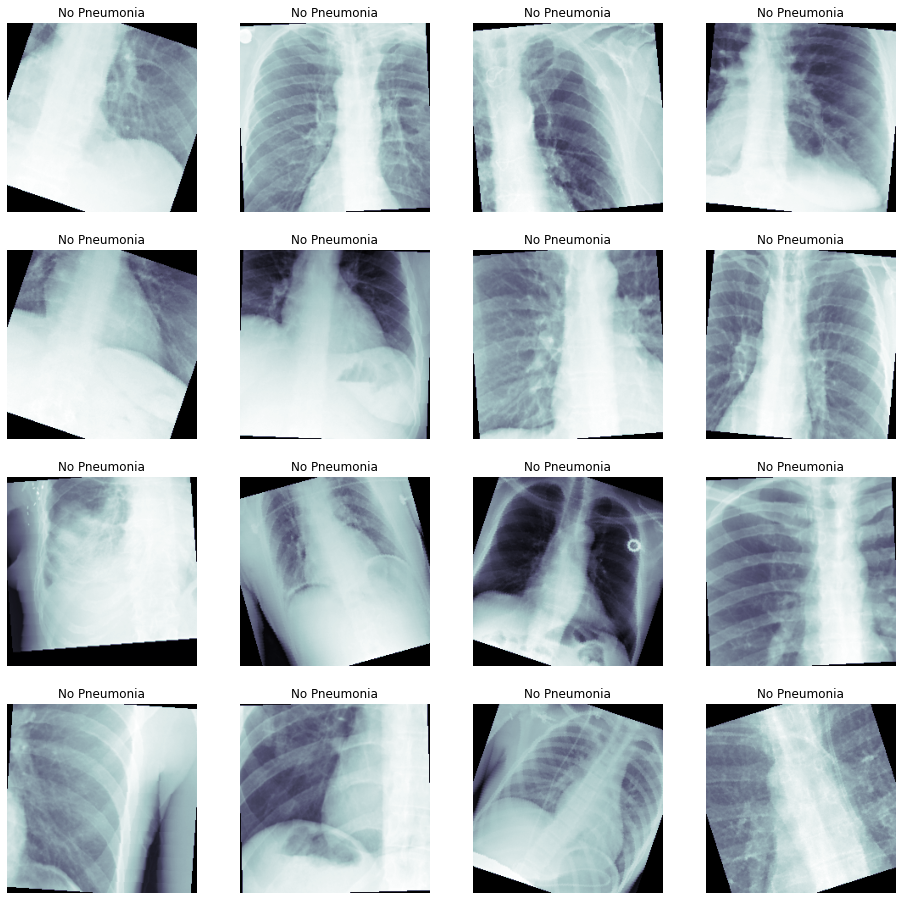

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(iter(train_gen))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[0,:,:], cmap = 'bone')
    if c_y == 1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    vgg_model = models.vgg16(pretrained=True)
    for param in vgg_model.parameters():
        param.requires_grad = False
    return vgg_model

In [13]:
class PneumoNet(nn.Module):
    def __init__(self, out_size):
        super(PneumoNet, self).__init__()
        self.vgg16 = load_pretrained_model()

        num_features = self.vgg16.classifier[6].in_features
        features = list(self.vgg16.classifier.children())[:-1] # Remove last layer
        # #    The VGG-16 is able to classify 1000 different labels; we just need 2 instead. In order to do that we are going replace the last fully connected layer of the model with a new one with 4 output features instead of 1000.
        # #    In PyTorch, we can access the VGG-16 classifier with model.classifier, which is an 6-layer array. We will replace the last entry.
        features.extend([nn.Linear(num_features, out_size)])# add Linear layer
        self.vgg16.classifier = nn.Sequential(*features)

    def forward(self, x):
        x = self.vgg16(x)
        features = self.vgg16.classifier[6]
        return x, features

def build_my_model():
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model,
    # you want to freeze before you compile
    
    # also make sure you set your optimizer, loss function, and metrics to monitor

    return PneumoNet(2).to(device)

model = build_my_model()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()# this includes a LogSoftmax layer added after the Linear layer

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code.
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Please note I've implemented the checkpoint and the early stopping in the next function.


In [14]:
def train_model(vgg, model_criterion, model_optimizer, num_epochs=10, patience=5):

    history_aux = {}
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    train_avg_loss_list = []
    train_avg_acc_list = []
    val_avg_loss_list = []
    val_avg_acc_list = []

    train_batches = len(train_gen)
    val_batches = len(val_gen)

    train_size = train_gen.dataset.len
    val_size = val_gen.dataset.len

    patience_aux = 0

    for epoch in range(num_epochs):

        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)

        for i, data in enumerate(train_gen):

            if i % 100 == 0:

                if i > 0:
                    avg_loss_aux = loss_train / ((i+1)*len(data[0]))
                    avg_acc_aux = acc_train / ((i+1)*len(data[0]))
                print("\rTraining batch {}/{}; mean_loss {}, mean_acc {} ".format(i, train_batches, avg_loss_aux, avg_acc_aux), end='', flush=True)

            # # Use half training dataset
            # if i >= train_batches / 2:
            #     break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs[0], 1)
            loss = model_criterion(outputs[0], labels)

            loss.backward()
            model_optimizer.step()

            loss_train += loss
            acc_train += torch.sum(preds == labels)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        train_avg_loss = loss_train / train_size
        train_avg_acc = acc_train / train_size

        train_avg_loss_list.append(train_avg_loss.cpu().detach().numpy())
        train_avg_acc_list.append(train_avg_acc.cpu().detach().numpy())

        vgg.train(False)
        vgg.eval()

        with torch.no_grad():
            for i, data in enumerate(val_gen):
                if i % 100 == 0:
                    if i > 0:
                        avg_loss_val_aux = loss_val / ((i+1)*len(data[0]))
                        avg_acc_val_aux = acc_val / ((i+1)*len(data[0]))
                    print("\rValidation batch {}/{}; mean_loss {}; mean_acc {}".format(i, val_batches, avg_loss_val_aux, avg_acc_val_aux), end='', flush=True)

                inputs, labels = data

                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs[0], 1)
                loss = criterion(outputs[0], labels)

                loss_val += loss
                acc_val += torch.sum(preds == labels.data)

                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

        val_avg_loss = loss_val / val_size
        val_avg_acc = acc_val / val_size
        val_avg_loss_list.append(val_avg_loss.cpu().detach().numpy())
        val_avg_acc_list.append(val_avg_acc.cpu().detach().numpy())

        print("\rEpoch {}, Training mean_loss/acc: {:.4f} / {:.4f}; Validation mean_loss/acc: {:.4f} / {:.4f}".format(epoch, train_avg_loss, train_avg_acc, val_avg_loss, val_avg_acc))

        if val_avg_acc > best_acc:
            print("\rval_binary_accuracy improved from {}".format(best_acc))
            print('-' * 40)
            best_acc = val_avg_acc
            best_model_wts = copy.deepcopy(vgg.state_dict())
            torch.save(vgg.state_dict(), 'PneumoVGG16_checkpoint.pt')

        else:
            patience_aux = patience_aux+1
            print("\rval_binary_accuracy did not improve from {}".format(best_acc))
            print('-' * 40)
            if patience_aux > patience:
                break


    elapsed_time = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)

    history_aux['train_avg_loss'] = train_avg_loss_list.cpu()
    history_aux['train_avg_acc']  = train_avg_acc_list.cpu()
    history_aux['val_avg_loss']   = val_avg_loss_list.cpu()
    history_aux['val_avg_acc']    = val_avg_acc_list.cpu()

    return vgg, history_aux

### Start training!

In [ ]:
## train your model
# Todo
# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)
vgg16, history = train_model(model, criterion, optimizer, num_epochs=10)
torch.save(vgg16.state_dict(), 'PneumoVGG16_weights.pt')
history = history.cpu()
history_df = pd.DataFrame(history)
history_df.to_csv('PneumoVGG16_history.csv')

Epoch 0/10
----------
Training batch 100/1123; mean_loss 0.00697733461856842, mean acc 0.9663366675376892 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [1]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model = PneumoNet(2)
my_model.load_state_dict(torch.load('PneumoVGG16_weights.pt'))
my_model.eval()

test_gen = make_val_gen(val_data, len(val_data))

with torch.no_grad():
    pred_Y = my_model(test_gen)
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
    # print(f'Predicted: "{predicted}", Actual: "{actual}"')
#pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

NameError: name 'PneumoNet' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score

def plot_auc(t_y, p_y):

    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    auc_pneumonia_aux = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = "Pneumonia AUC:{}".format(round(auc_pneumonia_aux,2)))
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    return auc_pneumonia, fpr, tpr, thresholds

## what other performance statistics do you want to include here besides AUC? 
# TPR - True Positive Rate
# PPV - Positive Predictive Value

def plot_precision_recall_curve(t_y, p_y):

    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    average_precision_score_aux = average_precision_score(t_y, p_y)

    plt.plot(recall, precision, label = "average_precision_score AUC:{}".format(round(average_precision_score_aux,2)))
    plt.legend()
    plt.xlabel('Recall (TPR)')
    plt.ylabel('Precision (PPV)')
    plt.show()

    return average_precision_score_aux, precision, recall, thresholds

valX_test, valY_test = next(iter(val_gen))

f1score = f1_score(valY_test, pred_Y)

#Also consider plotting the history of your model training:

def plot_f1score_curve(t_y, p_y):

    f1score_list = []
    thresh_list = []
    best_f1 = 0
    best_thres = None

    for t in np.arange(0.0, 1, 0.02):

        y_pred_class = p_y > t
        f1 = f1_score(t_y, y_pred_class)

        if best_f1 < f1:

            best_f1 = f1
            best_thres = t

        f1score_list.append(f1)
        thresh_list.append(t)

    plt.plot(thresh_list, f1score_list,
              label = 'Pneumonia optimal F1 Score:{} with threshold {})'.format(round(best_f1,4), round(best_thres,4)))
    plt.legend()
    plt.xlabel('thresh')
    plt.ylabel('f1')

    return best_thres, f1score_list, thresh_list


def plot_history(history_var):

    fig_aux, ax = plt.subplot(1, 2)
    #iterations=list(range(0,len(history_var['train_avg_loss'])))
    ax[0].plot(history_var['train_avg_loss'], labels = 'Avg Loss')
    ax[0].plot(history_var['train_avg_acc'], labels = 'Avg ACC')
    ax[0].set_title('Average Loss and ACC for Training set')
    ax[0].legend()
    ax[0].set_xlabel('iterations')
    ax[0].set_ylabel('Cross-entropy Loss')

    ax[1].plot(history_var['val_avg_loss'], labels = 'Avg Loss')
    ax[1].plot(history_var['val_avg_acc'], labels = 'Avg ACC')
    ax[1].set_title('Average Loss and ACC for Validation set')
    ax[1].legend()
    ax[1].set_xlabel('iterations')
    ax[1].set_ylabel('Accuracy')
    plt.show()

In [ ]:
## plot figures
auc_pneumonia, fpr_pneumonia, tpr_pneumonia, _ = plot_auc(valY_test, pred_Y)
average_precision_score_pneumonia, precision_pneumonia, recall_pneumonia, thresholds_pneumonia = plot_precision_recall_curve(valY_test, pred_Y)
best_threshold_pneumonia, f1score_list_pneumonia, thresh_list_pneumonia = plot_f1score_curve(valY_test, pred_Y)
history_df = pd.read_csv('PneumoVGG16_history.csv')
plot_history(history_df)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

threshold = ###
idx = (np.abs(thresholds_pneumonia - threshold)).argmin()

precision_optimal = precision_pneumonia[idx]
recall_optimal = recall_pneumonia[idx]
threshold_optimal = thresholds_pneumonia[idx]
def  f1_score_pr(precision,recall):
    return 2*(precision*recall)/(precision+recall)
f1score_optimal = f1_score_pr(precision_pneumonia[idx],recall_pneumonia[idx])

print('Optimal Threshold is: %.4f'%threshold_optimal)
print('Optimal Precision: %.4f'%precision_optimal)
print('Optimal Recall is: %.4f'%recall_optimal)
print('Optimal F1 Score is: %.4f'%f1score_optimal)
YOUR_THRESHOLD=threshold_optimal

In [ ]:
## Let's look at some examples of predicted v. true with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX_test[0:100], valY_test[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:
##my_model.config.to_json_file("my_model.json")

# NOTE: the purpose of this exercise is to save both the archictecture and the weights such that both can be loaded in
# inference.ipynb file. This is not the prefered way of saving a model in pytorch. Using the core pytorch SDK this is
# done as follows:
torch.save(my_model, 'my_model.pt')

# model_json = my_model.to_json()
# with open("my_model.json", "w") as json_file:
#     json_file.write(model_json)